In [1]:
!pip install swig
!pip install "gymnasium[box2d]"

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from collections import defaultdict

import seaborn as sns

import tensorflow as tf
import torch
from typing import Tuple

from tqdm.notebook import tqdm

import sys

2024-12-18 17:19:41.829280: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-18 17:19:42.290087: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import gymnasium as gym

In [5]:
from IPython.display import clear_output
import time

In [7]:
class BlackjackAgent:
    """
    A Reinforcement Learning agent that uses Q-learning to play the Blackjack game.

    The agent learns state-action values (Q-values) over time by interacting with the
    environment. It balances exploration and exploitation using an epsilon-greedy policy.
    """
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95
    ):
        """
        Initialize the BlackjackAgent with learning parameters and an empty Q-value table.

        Args:
            learning_rate (float): The rate at which the agent learns (alpha in Q-learning).
            initial_epsilon (float): The initial exploration rate for epsilon-greedy policy.
            epsilon_decay (float): The rate at which epsilon decays after each episode.
            final_epsilon (float): The minimum value epsilon can decay to.
            discount_factor (float, optional): The discount factor for future rewards (gamma). 
                                               Defaults to 0.95.
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: Tuple[int, int, bool]) -> int:
        """
        Select an action based on the epsilon-greedy policy.

        Args:
            obs (Tuple[int, int, bool]): The current state of the environment represented as 
                                         a tuple (player_sum, dealer_card, usable_ace).

        Returns:
            int: The chosen action (0 = stick, 1 = hit).
        """
        if np.random.random() < self.epsilon:
            return env.action_space.sample()  # Explore: take a random action
        else:
            return int(np.argmax(self.q_values[obs]))  # Exploit: take the best action

    def update(
        self,
        obs: Tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: Tuple[int, int, bool]
    ):
        """
        Update the Q-value for a state-action pair using the Q-learning update rule.

        Args:
            obs (Tuple[int, int, bool]): The current state of the environment.
            action (int): The action taken in the current state.
            reward (float): The reward received for taking the action.
            terminated (bool): Whether the episode has ended after this step.
            next_obs (Tuple[int, int, bool]): The resulting state after taking the action.
        """
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )
        self.q_values[obs][action] += self.lr * temporal_difference
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        """
        Decay the exploration rate epsilon after each episode.

        Epsilon decreases multiplicatively until it reaches the minimum value (final_epsilon).
        """
        self.epsilon = max(self.final_epsilon, self.epsilon * self.epsilon_decay)


Q-value function is used to estimate the optimal action to take in each state. The optimal action in a state is the one that maximazed the long-term reward.

In [13]:
# hyperparams
learning_rate = 0.01
n_episodes = 1000
start_epsilon = 1
epsilon_decay = start_epsilon / (n_episodes / 2) # reduce the exploration over time
final_epsilon = 0.1

agent = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon
)

In [17]:
env = gym.make('Blackjack-v1', render_mode='rgb_array', sab=True)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

for episode in tqdm(range(n_episodes), desc="Training Progress"):
    # clear_output()
    episode_finish = False
    obs, info = env.reset()  # Reset environment at start of episode

    # Run one episode
    while not episode_finish:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        agent.update(obs, action, reward, terminated, next_obs)
        # frame = env.render()
        # plt.imshow(frame)
        # plt.show()

        episode_finish = terminated or truncated
        obs = next_obs
        sys.stdout.flush()  # Force output to flush for the progress bar

    agent.decay_epsilon()

Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

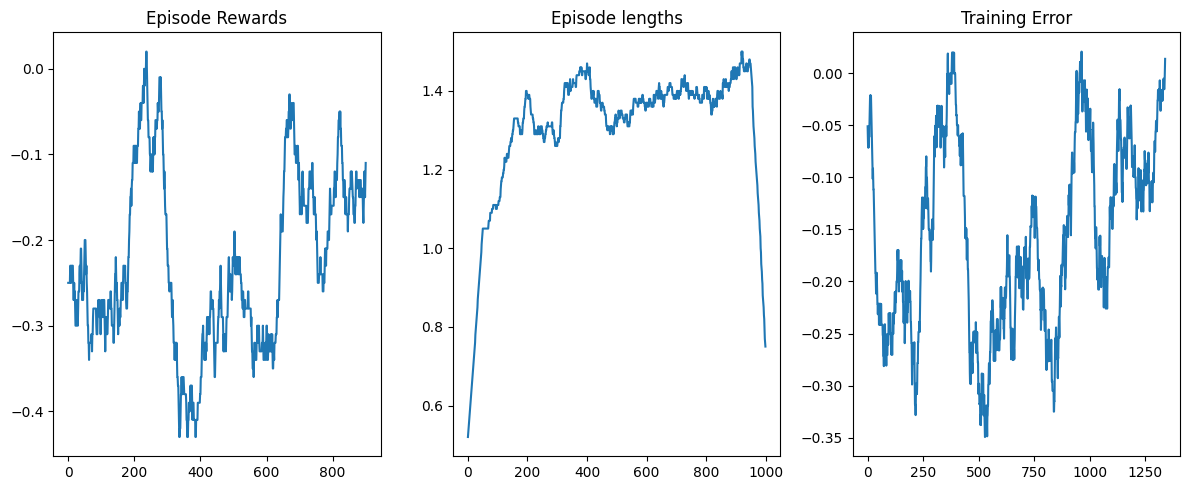

In [16]:
rolling_length = 100
fig, axs = plt.subplots(ncols=3, figsize=(12,5))

axs[0].set_title('Episode Rewards')
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode='valid'
    ) / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

axs[1].set_title('Episode lengths')
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode='same'
    ) / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)


axs[2].set_title('Training Error')
training_error_moving_average = (
    np.convolve(
        np.array(agent.training_error), np.ones(rolling_length), mode='same'
    ) / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

**Episode Rewards** helps identify trends in rewards (e.g., increasing rewards show the agent is improving).

**Episode Lengths** helps monitor if the agent's episodes are becoming shorter or longer:
- Shorter episodes might mean the agent is quickly achieving its goal (or failing fast).
- Longer episodes might indicate indecisive behavior or exploration.

**Training Error** helps analyze how the error decreases as the agent learns:
- High errors: The agent is still learning and updating Q-values aggressively.
- Low errors: The agent is converging, and Q-values stabilize.

AttributeError: 'list' object has no attribute 'desc'